#Importing essential Libraries

In [37]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler

from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imageio

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
image_path = '/content/drive/MyDrive/DL/Datasets/MNIST/testSet'

image_data = []

#Loading images
print("Loading Training Images...")

filenames = [os.path.join(image_path, img) for img in os.listdir(image_path)]
filenames.sort()
for img in filenames:
  image_arr = cv2.imread(img)  #One image of dim (W, H, 3)

  #Resizing  
  new_image = cv2.cvtColor(image_arr, cv2.COLOR_BGR2GRAY)
  image_data.append(new_image)
  
images = np.array(image_data)
print("Size of image array: ", images.shape)

Loading Training Images...
Size of image array:  (28000, 28, 28)


##Visualizing some images

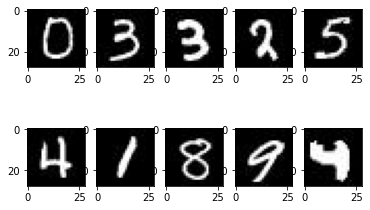

In [40]:
plt.figure(1)
plt.subplot(2,5,1)
plt.imshow(images[15], cmap= 'gray')
plt.subplot(2,5,2)
plt.imshow(images[16], cmap= 'gray')
plt.subplot(2,5,3)
plt.imshow(images[100], cmap= 'gray')
plt.subplot(2,5,4)
plt.imshow(images[200], cmap= 'gray')
plt.subplot(2,5,5)
plt.imshow(images[300], cmap= 'gray')
plt.subplot(2,5,6)
plt.imshow(images[400], cmap= 'gray')
plt.subplot(2,5,7)
plt.imshow(images[500], cmap= 'gray')
plt.subplot(2,5,8)
plt.imshow(images[600], cmap= 'gray')
plt.subplot(2,5,9)
plt.imshow(images[700], cmap= 'gray')
plt.subplot(2,5,10)
plt.imshow(images[800], cmap= 'gray')
plt.show()

## Doing some preprocessing

In [41]:
#Checking if gpu is available
if torch.cuda.is_available():
  print("cuda GPU is available")
  DEVICE = 'cuda'
else:
  print("GPU is not available")
  DEVICE = 'cpu'

cuda GPU is available


In [42]:
images = np.array(images, dtype= np.float32)
images = images/ 255.0

In [43]:
#Moving images to DEVICE
images = torch.tensor(images, device= DEVICE)
print(images.dtype)

torch.float32


In [44]:
images_vec = images.reshape(images.shape[0], -1)

In [45]:
print("shape of image after flattening them: ", images_vec.shape)

shape of image after flattening them:  torch.Size([28000, 784])


#Creating Network Architecture

credits: Professor [Justin Johnson](https://web.eecs.umich.edu/~justincj/)

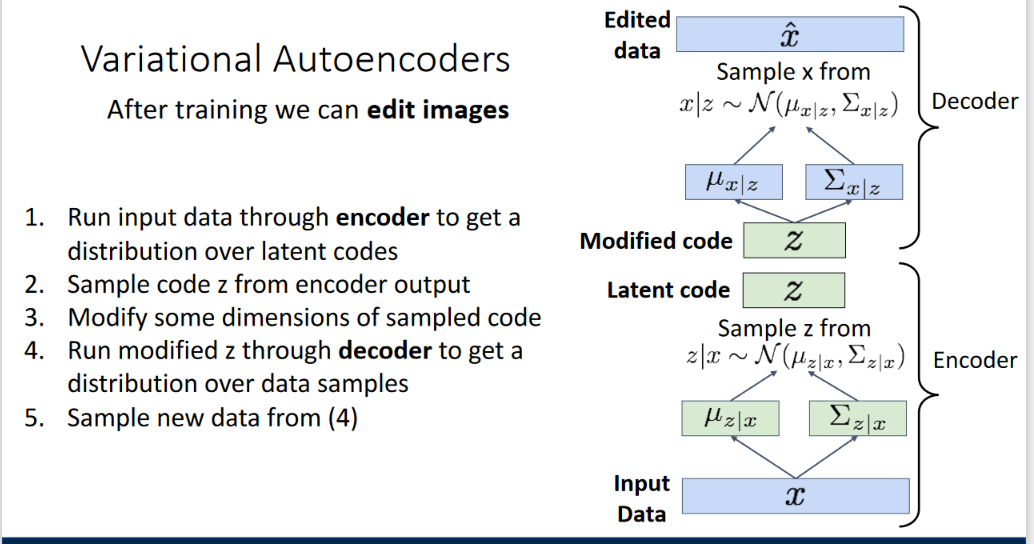

In [56]:
class Variational_Autoencoders(nn.Module):

  def __init__(self,input_dims, hidden_dims, z_shape ):     #Features is the dimension of Height and Width of the image
    super(Variational_Autoencoders, self).__init__()

    #Encoder Network
    self.encoder = nn.Sequential(
            nn.Linear(input_dims, hidden_dims),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(inplace=True),
        )
    
    #sapearte fully connected layer for mean. we will sample from mean and covariance to form the vector z which will go as input to decoder neywork
    self.mean_layer = nn.Linear(hidden_dims, z_shape)

    #sapearte fully connected layer for covariance
    self.log_covariance_layer = nn.Linear(hidden_dims, z_shape)

    #Decoder Network
    self.decoder = nn.Sequential(
            nn.Linear(z_shape, hidden_dims),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dims, input_dims),
            nn.Sigmoid(),                           #we use sigmoid when we use binary cross entropy loss
            #nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
        )
    
  def forward(self, input):   #input has shape(N, 784)

    #Passing through encoder network:
    out = self.encoder(input)

    out_mean = self.mean_layer(out)

    out_logcov = self.log_covariance_layer(out)

    #sampling from normal distribution with mean= out_mean and log covariance = out_logcov

    sigma = torch.sqrt(torch.exp(out_logcov))
    z = sigma * torch.randn_like(out_mean) + out_mean

    #Passing through decoder network:
    out = self.decoder(z)
  
    return out, out_mean, out_logcov



In [57]:
vae = Variational_Autoencoders(input_dims = images_vec.shape[1], hidden_dims = 500, z_shape = 20).to(device= DEVICE)

In [58]:
#Doing a forward pass through the network:
out, a, b = vae(images_vec[0:5])

In [59]:
out.shape

torch.Size([5, 784])

#Model Training:

In [60]:
optimizer = torch.optim.Adam(vae.parameters(), lr=0.0001)        #update the weights of the network vae
loss_type = nn.BCELoss()
step_lr = lr_scheduler.StepLR(optimizer, step_size= 2000, gamma = 0.5)  

In [61]:
#Model Training
loss_graph = []
num_epochs = 20000
num_train = images_vec.shape[0]
batch_size = 200
vae.train()
for i in range(num_epochs):
  random_no = torch.randint(0, num_train, (batch_size,))
  x_batch = images_vec[random_no]
  
  optimizer.zero_grad()
  y_pred, out_mean, out_logcov = vae(x_batch)
  #loss = loss_type(y_pred, x_batch)

  y1 = nn.functional.binary_cross_entropy(y_pred, x_batch, reduction='sum')

  y1_ = 1 + out_logcov - out_mean**2 - torch.exp(out_logcov)
  y1_ = -0.5 * y1_.sum()
  loss = y1 + y1_
  loss /= out_mean.shape[0]
  loss.backward()
  optimizer.step()

  #schedular step
  #step_lr.step()

  loss_graph.append(loss.cpu().item())
  if i%10==0:
    print("Epoch: ", i+1, ", loss is: ", loss.cpu().item())
    #print("Learning rate is: ", optimizer.state_dict()['param_groups'][0]['lr'])

Epoch:  1 , loss is:  543.9769897460938
Epoch:  11 , loss is:  529.8602294921875
Epoch:  21 , loss is:  495.17486572265625
Epoch:  31 , loss is:  387.1167907714844
Epoch:  41 , loss is:  282.6117858886719
Epoch:  51 , loss is:  236.44354248046875
Epoch:  61 , loss is:  227.40562438964844
Epoch:  71 , loss is:  216.0097198486328
Epoch:  81 , loss is:  222.0916290283203
Epoch:  91 , loss is:  221.597900390625
Epoch:  101 , loss is:  216.7613983154297
Epoch:  111 , loss is:  215.67320251464844
Epoch:  121 , loss is:  208.96946716308594
Epoch:  131 , loss is:  217.09033203125
Epoch:  141 , loss is:  213.22366333007812
Epoch:  151 , loss is:  217.65457153320312
Epoch:  161 , loss is:  212.823486328125
Epoch:  171 , loss is:  220.21763610839844
Epoch:  181 , loss is:  212.03372192382812
Epoch:  191 , loss is:  209.7147979736328
Epoch:  201 , loss is:  209.94110107421875
Epoch:  211 , loss is:  211.42572021484375
Epoch:  221 , loss is:  216.75941467285156
Epoch:  231 , loss is:  215.667861938

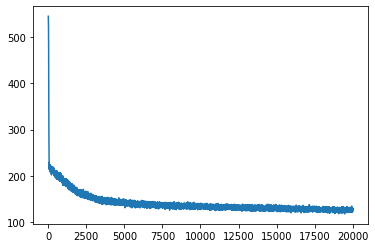

In [62]:
#Loss Curve
#Loss Graph
plt.plot(loss_graph)
plt.show()

In [63]:
vae.eval()
out, a, b = vae(images_vec[0:5])

Actual output: 


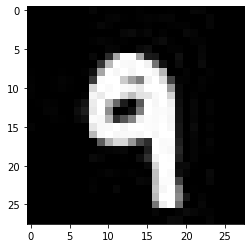

Output from the model: 


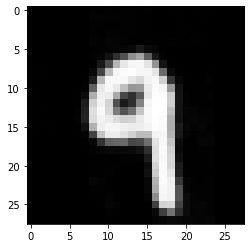

In [64]:
print("Actual output: ")
plt.imshow(images[3].cpu().numpy(), cmap= 'gray')
plt.show()

print("Output from the model: ")
plt.imshow(out[3].reshape(28,28).detach().cpu().numpy(), cmap= 'gray')
plt.show()

we can see that the model is able to replicate the input so now we can use the vector z (sample from mean and logvar) to produce different outputs

In [65]:
def generate_images(input):
  out = vae.decoder(input)
  return out

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


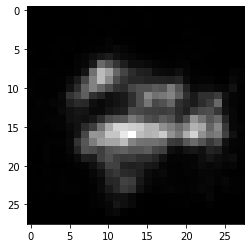

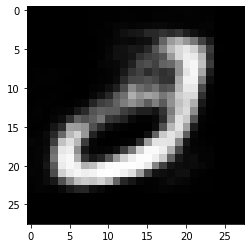

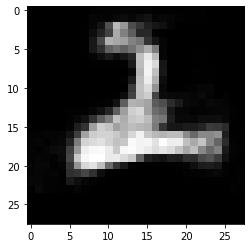

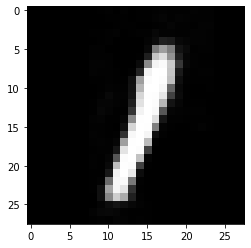

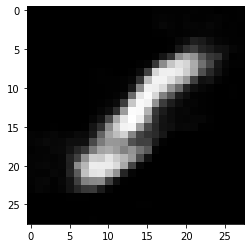

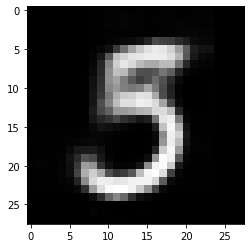

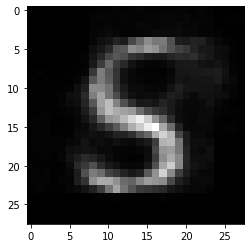

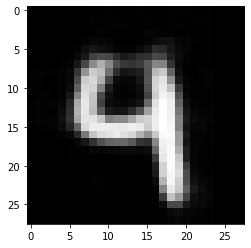

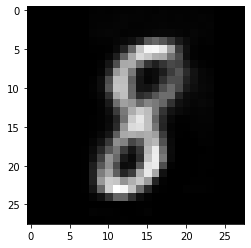

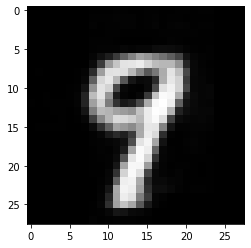

In [66]:
z = torch.randn(10, 20)
z = torch.tensor(z, device = DEVICE, dtype = torch.float32)

for i in range(z.shape[0]):
  img_out = generate_images(z)
  plt.imshow(img_out[i].reshape(28,28).detach().cpu().numpy(), cmap= 'gray')
  plt.show()
